In [2]:
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet

In [2]:
def compute_expec_loss_cond_epsilon(Z_i_star, V, sigma):
    """
    Compute the given expression in PyTorch.
    
    Args:
        Z_i_star (torch.Tensor): The Z_{i*} vector, shape (p,1).
        V (torch.Tensor): The V matrix, shape (p,p).
        sigma (float): The standard deviation (scalar).
        
    Returns:
        torch.Tensor: The loss and derivative of the loss with respect to V
    """
    # Initialize normal distribution for standard normal
    normal = Normal(0, 1)

    # Compute intermediate values
    term = -V @ Z_i_star / sigma  # Shape: scalar
    phi = normal.log_prob(term).exp()  # \phi(x), scalar
    Phi = normal.cdf(term)  # \Phi(x), scalar

    # Compute the element-wise operations
    vec = (phi +  term * Phi) * sigma
    
    # Final computation
    loss = torch.sum(vec)
    deriv = - Phi @ Z_i_star.T
    
    return  loss, deriv



def compute_raw_loss(Z_i_star, V, sigma):
    """
    Compute the given loss in PyTorch.
    
    Args:
        Z_i_star (torch.Tensor): The Z_{i*} vector, shape (p,1).
        V (torch.Tensor): The V matrix, shape (p,p).
        sigma (float): The standard deviation (scalar).
        
    Returns:
        torch.Tensor: The result of the expression, shape (p,).
    """
    p = Z_i_star.shape[0]
    noise_gauss = Normal(0, sigma)
    relu = nn.ReLU()
    
    epsilon = noise_gauss.sample((p,)).view(p,1)
    loss = torch.sum(relu((- Z_i_star - epsilon).T @ V))
    return loss
    
    
def proj_Op_tangent_space_at_W(M, W):
    """
    Projects a matrix M onto the tangent space of the orthogonal group O_p at W.
    
    Parameters:
        M (torch.Tensor or np.ndarray): The matrix to be projected, of shape (p, p).
        W (torch.Tensor or np.ndarray): A point in the orthogonal group O_p, of shape (p, p)
                                         
    Returns:
        torch.Tensor or np.ndarray: The projection of M onto the tangent space of O_p at W,
                                    of shape (p, p).
    """
    proj = W @ (W.T @ M - M.T @ W) / 2
    return proj
    

def sample_Z_i_star(p):
    """
    Samples Z_i_star uniformly from the standard basis of R^p.
    
    Args:
        p (int): Dimension of the space R^p.
        
    Returns:
        torch.Tensor: A p-dimensional tensor representing the sampled standard basis vector.
    """
    # Create an identity matrix of shape (p, p) where rows are standard basis vectors
    standard_basis = torch.eye(p)
    
    # Randomly choose one row (basis vector) uniformly
    idx = torch.randint(0, p, (1,)).item()
    Z_i_star = standard_basis[idx]
    
    return Z_i_star



In [3]:
def compute_expec_loss_discrete_2D(z1, z2, p, theta, sigma):
    
    """
    Compute the expected loss conditioning on epsilon  in PyTorch.
    
    Args:
        Z_i_star (torch.Tensor): The Z_{i*} vector, shape (p,1).
        V (torch.Tensor): The V matrix, shape (p,p).
        sigma (float): The standard deviation (scalar).
        
    Returns:
        torch.Tensor: The loss and derivative of the loss with respect to V
    """

    normal = Normal(0, 1)
    theta = torch.tensor([theta * (np.pi) - (1/2 * np.pi)], dtype = torch.float32)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    V = torch.tensor([[cos_theta, -sin_theta],
                      [sin_theta,  cos_theta]])
    
    z1 = torch.Tensor(z1).view(2, 1)
    z2 = torch.Tensor(z2).view(2, 1)

    term_1 = -V @ z1 / sigma
    term_2 = -V @ z2 / sigma

    phi_1 = normal.log_prob(term_1).exp()
    phi_2 = normal.log_prob(term_2).exp()
    
    Phi_1 = normal.cdf(term_1)
    Phi_2 = normal.cdf(term_2)
    
    loss = torch.sum((phi_1 + term_1 * Phi_1) * sigma * p + (phi_2 + term_2 * Phi_2) * sigma * (1 - p)) 
    return loss
    

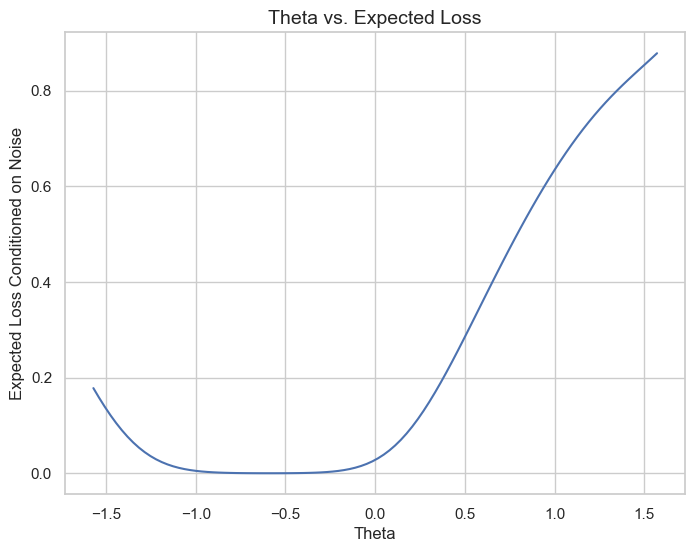

In [16]:
z1, z2, sigma = [0.1, 0.9], [0.2, 0.8], 0.2
p = 0.5
# Generate theta values and compute the outputs
theta_values = np.linspace(0, 1, 100)
y_values = [compute_expec_loss_discrete_2D(z1, z2, p, theta, sigma).item() for theta in theta_values]

# Create a DataFrame for easier plotting with sns
data = pd.DataFrame({
    'Theta': theta_values * (np.pi) - (1/2 * np.pi),
    'Output': y_values
})

# Plot using seaborn
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))
sns.lineplot(x='Theta', y='Output', data=data)
plt.title("Theta vs. Expected Loss", fontsize=14)
plt.xlabel("Theta", fontsize=12)
plt.ylabel("Expected Loss Conditioned on Noise", fontsize=12)
plt.show()

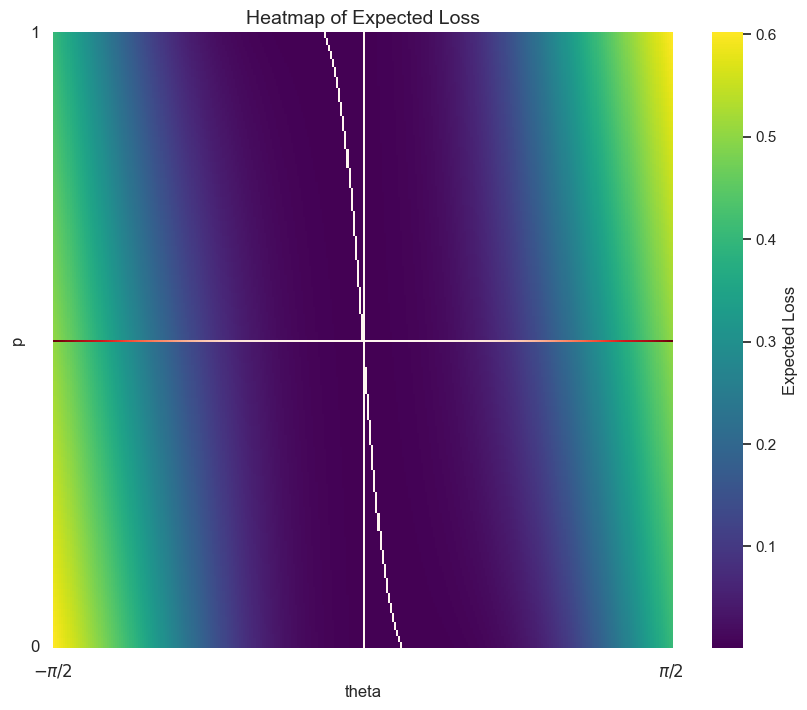

In [23]:
# Parameters
z1, z2, sigma = [0.4, 0.6], [0.6, 0.4], 0.2
grid_size = 300

# Generate grid for theta (x-axis) and p (y-axis)
theta_values = np.linspace(0, 1, grid_size)
p_values = np.linspace(0, 1, grid_size)

# Initialize output matrix
output_matrix = np.zeros((grid_size, grid_size))

# Compute the function over the grid with adjusted coordinate system
for i, p in enumerate(p_values):
    for j, theta in enumerate(theta_values):
        result = compute_expec_loss_discrete_2D(z1, z2, p, theta, sigma)
        output_matrix[(grid_size - i) - 1, j] = result.item()  # Flip the rows for correct visualization
        
# Create a mask for the row-wise minimums
highlight_matrix = np.zeros_like(output_matrix, dtype=bool)
for row_idx, row in enumerate(output_matrix):
    min_col_idx = np.argmin(row)  # Find the column index of the minimum
    highlight_matrix[row_idx, min_col_idx] = True  # Mark the minimum position
    highlight_matrix[int(grid_size/2), :] = True
    highlight_matrix[:, int(grid_size/2)] = True
         

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(output_matrix, 
            xticklabels=False,  # Suppress default x-axis tick labels
            yticklabels=False,  # Suppress default y-axis tick labels
            cmap='viridis', 
            cbar_kws={'label': 'Expected Loss'})

# Overlay the red-highlighted heatmap for row minima
sns.heatmap(output_matrix, 
            xticklabels=False, 
            yticklabels=False, 
            cmap='Reds',  # Red colormap for highlighting
            cbar=False,  # No additional color bar
            mask=~highlight_matrix,  # Highlight only the minima
            alpha=1)  # Opaque for highlighted cells


# Add custom ticks for a Cartesian-like grid
plt.xticks([0, grid_size - 1], [r"$-\pi/2$", r"$\pi/2$"], fontsize=12)
plt.yticks([grid_size - 1, 0], [0, 1], fontsize=12)  # P ticks (flipped correctly)

# Add axis labels and title
plt.xlabel("theta", fontsize=12)
plt.ylabel("p", fontsize=12)
plt.title("Heatmap of Expected Loss", fontsize=14)
plt.show()


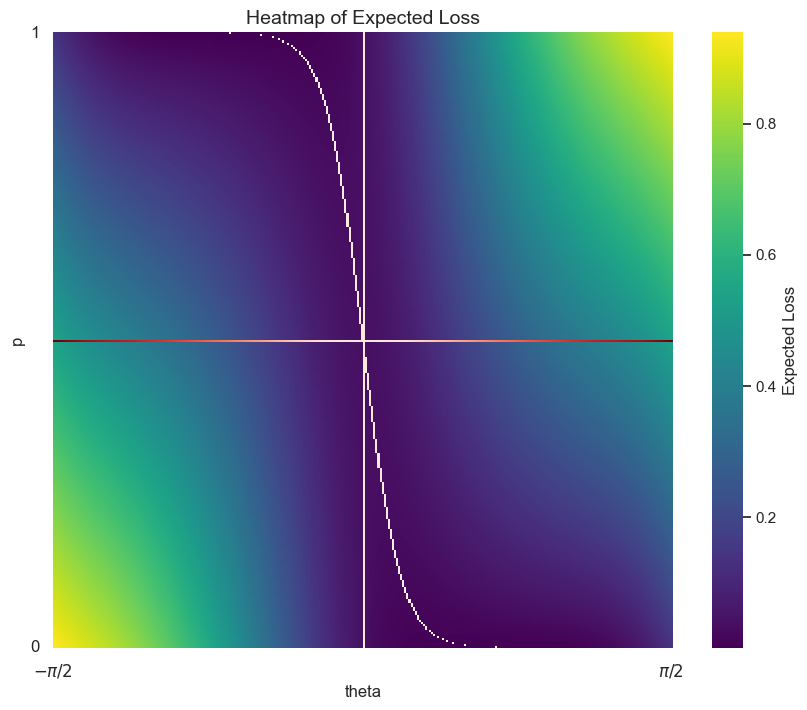

In [24]:
# Parameters
z1, z2, sigma = [0.1, 0.9], [0.9, 0.1], 0.2
grid_size = 300

# Generate grid for theta (x-axis) and p (y-axis)
theta_values = np.linspace(0, 1, grid_size)
p_values = np.linspace(0, 1, grid_size)

# Initialize output matrix
output_matrix = np.zeros((grid_size, grid_size))

# Compute the function over the grid with adjusted coordinate system
for i, p in enumerate(p_values):
    for j, theta in enumerate(theta_values):
        result = compute_expec_loss_discrete_2D(z1, z2, p, theta, sigma)
        output_matrix[(grid_size - i) - 1, j] = result.item()  # Flip the rows for correct visualization
        
# Create a mask for the row-wise minimums
highlight_matrix = np.zeros_like(output_matrix, dtype=bool)
for row_idx, row in enumerate(output_matrix):
    min_col_idx = np.argmin(row)  # Find the column index of the minimum
    highlight_matrix[row_idx, min_col_idx] = True  # Mark the minimum position
    highlight_matrix[int(grid_size/2), :] = True
    highlight_matrix[:, int(grid_size/2)] = True
         

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(output_matrix, 
            xticklabels=False,  # Suppress default x-axis tick labels
            yticklabels=False,  # Suppress default y-axis tick labels
            cmap='viridis', 
            cbar_kws={'label': 'Expected Loss'})

# Overlay the red-highlighted heatmap for row minima
sns.heatmap(output_matrix, 
            xticklabels=False, 
            yticklabels=False, 
            cmap='Reds',  # Red colormap for highlighting
            cbar=False,  # No additional color bar
            mask=~highlight_matrix,  # Highlight only the minima
            alpha=1)  # Opaque for highlighted cells


# Add custom ticks for a Cartesian-like grid
plt.xticks([0, grid_size - 1], [r"$-\pi/2$", r"$\pi/2$"], fontsize=12)
plt.yticks([grid_size - 1, 0], [0, 1], fontsize=12)  # P ticks (flipped correctly)

# Add axis labels and title
plt.xlabel("theta", fontsize=12)
plt.ylabel("p", fontsize=12)
plt.title("Heatmap of Expected Loss", fontsize=14)
plt.show()


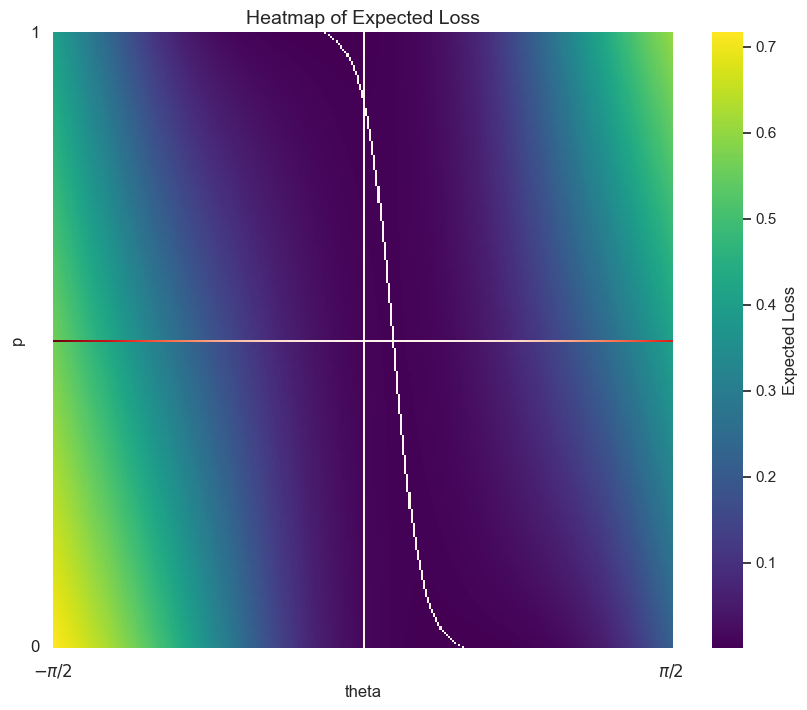

In [25]:
# Parameters
z1, z2, sigma = [0.4, 0.6], [0.7, 0.2], 0.2
grid_size = 300

# Generate grid for theta (x-axis) and p (y-axis)
theta_values = np.linspace(0, 1, grid_size)
p_values = np.linspace(0, 1, grid_size)

# Initialize output matrix
output_matrix = np.zeros((grid_size, grid_size))

# Compute the function over the grid with adjusted coordinate system
for i, p in enumerate(p_values):
    for j, theta in enumerate(theta_values):
        result = compute_expec_loss_discrete_2D(z1, z2, p, theta, sigma)
        output_matrix[(grid_size - i) - 1, j] = result.item()  # Flip the rows for correct visualization
        
# Create a mask for the row-wise minimums
highlight_matrix = np.zeros_like(output_matrix, dtype=bool)
for row_idx, row in enumerate(output_matrix):
    min_col_idx = np.argmin(row)  # Find the column index of the minimum
    highlight_matrix[row_idx, min_col_idx] = True  # Mark the minimum position
    highlight_matrix[int(grid_size/2), :] = True
    highlight_matrix[:, int(grid_size/2)] = True
         

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(output_matrix, 
            xticklabels=False,  # Suppress default x-axis tick labels
            yticklabels=False,  # Suppress default y-axis tick labels
            cmap='viridis', 
            cbar_kws={'label': 'Expected Loss'})

# Overlay the red-highlighted heatmap for row minima
sns.heatmap(output_matrix, 
            xticklabels=False, 
            yticklabels=False, 
            cmap='Reds',  # Red colormap for highlighting
            cbar=False,  # No additional color bar
            mask=~highlight_matrix,  # Highlight only the minima
            alpha=1)  # Opaque for highlighted cells


# Add custom ticks for a Cartesian-like grid
plt.xticks([0, grid_size - 1], [r"$-\pi/2$", r"$\pi/2$"], fontsize=12)
plt.yticks([grid_size - 1, 0], [0, 1], fontsize=12)  # P ticks (flipped correctly)

# Add axis labels and title
plt.xlabel("theta", fontsize=12)
plt.ylabel("p", fontsize=12)
plt.title("Heatmap of Expected Loss", fontsize=14)
plt.show()


In [14]:
# Example usage
p = 2
Z_i_star = sample_Z_i_star(p).view(p, 1)  # Example Z_{i*} vector (p=10)
# Z_i_star = torch.randn(p).view(p, 1)  # Example Z_{i*} vector (p=10)
V = torch.eye(p)        # Example V vector (p=10)
sigma = 1.0                 # Example scalar sigma

compute_raw_loss(Z_i_star, V, sigma),compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)[0]

(tensor(0.3757), tensor(0.4823))

To verify empirically that the expectation computation, and the derivative computation is correct.

In [15]:
n, p = 10000, 2
sigma = 1.0 
V = torch.eye(p) 


raw_loss = []
conditional_epsilon = []

for i in range(n):
    Z_i_star = sample_Z_i_star(p).view(p, 1)
    # Z_i_star = dir_distr.sample((1,)).view(p, 1)  # Example Z_{i*} vector (p=10)
    conditional_epsilon.append(compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)[0])
    raw_loss.append(compute_raw_loss(Z_i_star, V, sigma))
    
# Difference in mean
print(f"the difference between the mean raw loss and the mean loss conditional on epsilon is {torch.mean(torch.tensor(conditional_epsilon)) - torch.mean(torch.tensor(raw_loss))}" )

# Variance of the two lists
# print(torch.var(torch.tensor(conditional_epsilon)), torch.var(torch.tensor(raw_loss)))

V = torch.eye(p) 
V.requires_grad_(True)
result = compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)
result[0].backward()
print(f"the difference between computed derivative and autograd is {torch.norm(V.grad - result[1])}")

the difference between the mean raw loss and the mean loss conditional on epsilon is -0.0009696483612060547
the difference between computed derivative and autograd is 1.4901161193847656e-08


In [16]:
n, p = 10000, 10
sigma = 0.1
V = torch.eye(p) 
dir_distr = Dirichlet(torch.ones(p)*5)


derivative_across_n = torch.zeros(p, p)

for i in range(n):
    # Z_i_star = sample_Z_i_star(p).view(p, 1)
    Z_i_star = dir_distr.sample((1,)).view(p, 1)  # Example Z_{i*} vector (p=10)
    derivative_across_n = derivative_across_n + compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)[1]
    
avg_deriv = derivative_across_n/n

proj_avg_deriv = proj_Op_tangent_space_at_W(avg_deriv, V)

print(torch.norm(proj_Op_tangent_space_at_W(avg_deriv, V), p = "fro"))

tensor(0.0012)


In [8]:
normal = Normal(0, 1)
phi = normal.cdf
dir_distr = Dirichlet(torch.ones(3))

trans = torch.tensor([[0,1], [1, 0]], dtype= torch.float32)

u = dir_distr.sample((1,))[:,:2].T
v = trans @ u
torch.svd(phi(u) @ u.T + phi(v) @ v.T)
phi(u) @ u.T + phi(v) @ v.T

tensor([[0.3781, 0.3054],
        [0.3054, 0.3781]])

RGD stuff

In [ ]:
# step 1. sample latent position z
# step 2. generate noise
# step 3. minimize the loss function, and find V

from src import Simulation as sim
import torch.optim as optim


class V_distr: 
    def __init__(self, sigma, n, alpha):
        self.sigma = sigma
        self.noise_distr = Normal(0, sigma)
        self.Z = sim.ABC.init_Z(n, torch.as_tensor(alpha, dtype = torch.float32))
        # self.Z = torch.kron(torch.eye(p), torch.ones(int(n/K))).T
        self.Z_noise = self.sample()
        
    def sample(self):
        n, p = self.Z.shape
        noise = self.noise_distr.sample((n, p))
        Z_noise = self.Z + noise
        return(Z_noise[:, :(p-1)])
    
    @staticmethod
    def theta_V(theta):
        """ For simplicity, the input theta takes value from 0 to 1, we transform it to -pi/2 to pi/2"""
        # theta = theta * (np.pi) - (1/2 * np.pi)
        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)
        V = torch.stack([
                torch.stack([cos_theta, -sin_theta]),
                torch.stack([sin_theta,  cos_theta])
            ])
        return(V)    
    
    @staticmethod
    def decompose(W):
        sym = (W + W.T)/2
        skew = (W - W.T)/2
        return({"sym": sym, "skew": skew})
        
    

    @staticmethod
    def computing_R_hessian(V, W, sigma, z): 
        z = z.view(-1, 1)
        
        normal = Normal(0, 1)
        def phi(x):
            return(torch.exp(normal.log_prob(x)))
        Phi = normal.cdf
        decomp = V_distr.decompose
        Omega = torch.linalg.solve(V, W)
        
        E_grad = -Phi(- V @ z/sigma) @ z.T 
        E_hess = torch.diag(phi(-V @ z / sigma).squeeze(dim = 1)) @ W @ z @ z.T / sigma
        
        result = V @ decomp(V.T @ E_hess - Omega @ decomp(V.T @ E_grad)["sym"])["skew"]

        return(result)   
    
    @staticmethod
    def computing_R_hessian_sum(V, W, sigma, Z):
        hessians = [V_distr.computing_R_hessian(V, W, sigma, z) for z in Z]
        return torch.stack(hessians, dim=0).sum(dim=0)
    
    
    def loss(self, theta):
        relu = nn.ReLU()
        V = V_distr.theta_V(theta)
        loss = torch.sum(relu((- self.Z_noise) @ V))
        return(loss)
    
    def optimize_theta(self, steps=200):
        theta = torch.tensor(0, dtype=torch.float32, requires_grad=True)
        optimizer = optim.LBFGS([theta], lr=0.1, max_iter=20, history_size=10)

        def closure():
            optimizer.zero_grad()
            loss = self.loss(theta)
            loss.backward()
            return loss
        
        for step in range(steps):
            optimizer.step(closure)

        return theta

    @staticmethod
    def average_off_diagonals(matrix: torch.Tensor) -> torch.Tensor:
        # Ensure the matrix is 2x2
        assert matrix.shape == (2, 2), "The matrix must be 2x2."
        
        # Extract off-diagonal elements:
        # For a 2x2 matrix, these are matrix[0,1] and matrix[1,0].
        off_diagonals = torch.tensor([matrix[0, 1], matrix[1, 0]])
        
        # Compute the average of the absolute values
        return off_diagonals.abs().mean()
    
    
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################
    @staticmethod
    def R_hessian_proc(V, W, Z, Z_hat): 
        
        decomp = V_distr.decompose
        Omega = torch.linalg.solve(V, W)
        
        E_grad = -2 * Z_hat.T @ (Z - Z_hat @ W)
        E_hess = 2 * Z_hat.T @ Z_hat @ W
        
        result = V @ decomp(V.T @ E_hess - Omega @ decomp(V.T @ E_grad)["sym"])["skew"]

        return(result)   
    
    def optimize_V(self):
        n, p = self.Z.shape
        Z = self.Z[:, :(p-1)]
        Z_hat = self.Z_noise
        
        M = Z.T @ Z_hat
        U, S, V = torch.linalg.svd(M)
        R = V @ U.T
        
        return(R)



In [ ]:
sigma, alpha, n, p = 0.2, [[10,1,1], [1,10,1], [1,1,10]], 9000, 3
mod = V_distr(sigma, alpha, n)

theta = mod.optimize_theta().detach()
# V = V_distr.theta_V(theta)

Z = mod.Z[:, :(p-1)]
V = torch.eye(2)
W = torch.tensor([[0, 1], [-1,0]], dtype = torch.float32)

R_hess = V_distr.computing_R_hessian_sum(V, W, 0.2, Z)

R_hess_inv = torch.linalg.inv(R_hess)

R_cov = V_distr.average_off_diagonals(R_hess_inv)

In [ ]:
def simulate(n):
    sigma, alpha = 0.2, [[10,1,1], [1,10,1], [1,1,10]]
    # theta = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)

    theta_list = []
    theoretical_cov = []
    for i in range(100):
        mod = V_distr(sigma, n, alpha)
        # theta_list.append(mod.optimize_theta().detach().item())

        Z = mod.Z[:, :(p-1)]
        V = torch.eye(2)
        W = torch.tensor([[0, 1], [-1,0]], dtype = torch.float32)

        R_hess = V_distr.computing_R_hessian_sum(V, W, sigma, Z)

        R_hess_inv = torch.linalg.inv(R_hess)

        R_cov = V_distr.average_off_diagonals(R_hess_inv)

        theta = mod.optimize_theta().detach().item()
        
        theta_list.append(theta)
        theoretical_cov.append(R_cov.detach().item())
        
    return({"emp": torch.arcsin(torch.tensor(theta_list)).var(), "theo": torch.tensor(theoretical_cov).mean()})

In [78]:
results = []

# Loop over n from 3000 to 21000 in increments of 3000.
for n in range(3000, 21001, 3000):
    result = simulate(n)
    
    # Convert torch tensors to Python floats if needed.
    emp_val = result["emp"].item() if isinstance(result["emp"], torch.Tensor) else result["emp"]
    theo_val = result["theo"].item() if isinstance(result["theo"], torch.Tensor) else result["theo"]
    
    results.append({"n": n, "emp": emp_val, "theo": theo_val})

# Create the DataFrame.
df = pd.DataFrame(results)
print(df)

       n       emp      theo
0   3000  0.000065  0.000748
1   6000  0.000032  0.000374
2   9000  0.000016  0.000249
3  12000  0.000012  0.000187
4  15000  0.000013  0.000150
5  18000  0.000009  0.000125
6  21000  0.000007  0.000107


<Axes: xlabel='n', ylabel='ratio'>

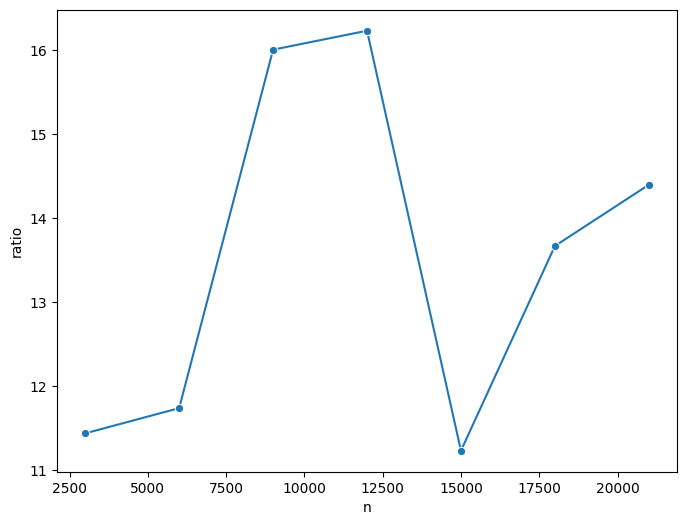

In [79]:
# Assuming 'df' is your DataFrame with columns 'n', 'emp', and 'theo'
df['ratio'] = df['theo'] / df['emp']

# Create the plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='n', y='ratio', marker='o')

OLS

In [100]:
# step 1. sample latent position z
# step 2. generate noise
# step 3. minimize the loss function, and find V

from src import Simulation as sim
import torch.optim as optim

alpha = [[10,1,1], [1,10,1], [1,1,10]]
fixed_Z = sim.ABC.init_Z(30000, torch.as_tensor(alpha, dtype = torch.float32))

class V_distr_prc: 
    def __init__(self, sigma, n):
        self.sigma = sigma
        self.noise_distr = Normal(0, sigma)
        self.Z = fixed_Z[:n, :]
        self.Z_noise = self.sample()
        
    def sample(self):
        n, p = self.Z.shape
        noise = self.noise_distr.sample((n, p))
        Z_noise = self.Z + noise
        return(Z_noise[:, :(p-1)])
    
    
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

    def OLS_sol_V(self):

        n, p = self.Z.shape
        Z = self.Z[:, :(p-1)]
        Z_hat = self.Z_noise

        sol = torch.linalg.solve(Z_hat.T @ Z_hat, Z_hat.T @ Z)
        
        return(sol)
    
    def OLS_var(self):
        
        Z_hat = self.Z_noise
        var_mat = np.square(self.sigma) * torch.linalg.inv(Z_hat.T@ Z_hat)
        
        return(var_mat)


In [103]:
def simulate_ols(n, iter, sigma = sigma):
    sol_list = []
    for _ in range(iter):
        mod = V_distr_prc(sigma, n)
        sol_list.append(mod.OLS_sol_V())
    sol_tensor = torch.stack(sol_list)
    theo_var = mod.OLS_var()
    return({"sol": sol_tensor, "theo_var": theo_var})
        

In [152]:
import sys

results = []

# Loop over n from 3000 to 21000 in increments of 3000.
for n in range(3000, 40001, 3000):
    result = simulate_ols(n, 10000, 0.2)
    
    emp_var = torch.var(result['sol'], dim = 0)
    theo_var = torch.diag(torch.var(result['theo_var'], dim = 0))
    
    emp_var_00 = emp_var[:1,:1].item()
    emp_var_01 = emp_var[:1,1:2].item()
    emp_var_10 = emp_var[1:2,:1].item()
    emp_var_11 = emp_var[1:2,1:2].item()

    theo_var_0 = torch.diag(result['theo_var'])[0].item()
    theo_var_1 = torch.diag(result['theo_var'])[1].item()
    
    results.append({"n": n, 
                    "emp_00": emp_var_00, 
                    "emp_01": emp_var_01,
                    "emp_10": emp_var_10,
                    "emp_11": emp_var_11,
                    "theo_0": theo_var_0,
                    "theo_1": theo_var_1})
    sys.stdout.write(f"\r Just finished {n}   ")

# Create the DataFrame.
df = pd.DataFrame(results)


 Just finished 39000   

In [153]:
df.to_csv(r"temp_df/ols_sol_var.csv")

<Axes: xlabel='n', ylabel='ratio'>

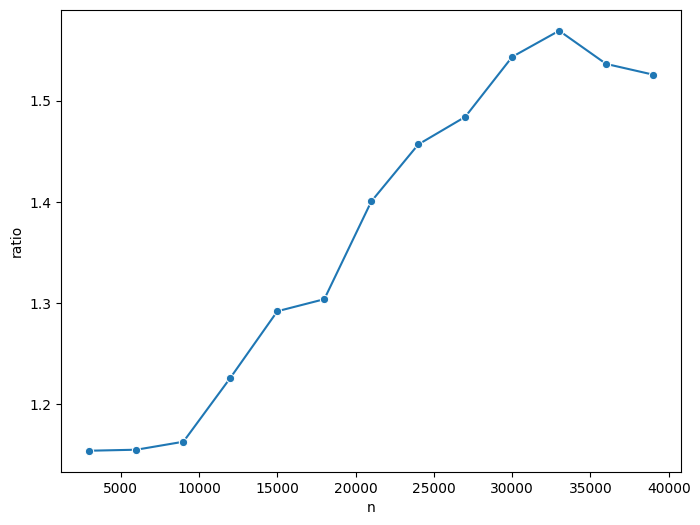

In [154]:
# Assuming 'df' is your DataFrame with columns 'n', 'emp', and 'theo'
df['ratio'] = df['theo_0'] / df['emp_00']

df_temp = df[df['ratio'] < 2]
# Create the plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_temp, x='n', y='ratio', marker='o')